In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# # Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import  process_data, get_train_and_val_loader

# import all the models from models module
from models import Swin_Transformer
# from util.video_swin_transformer import SwinTransformer3D
import torch.optim.lr_scheduler as lr_scheduler

import warnings

device = get_device()

EXTRACT_DATA = False

c:\Users\ahmed\anaconda3\envs\vstp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7'


You are using device: cpu


In [2]:
if EXTRACT_DATA:
    # # Data inputs for CNN and Swin Transformer baseline
    # disable pyav warning
    warnings.filterwarnings("ignore", message="Accurate seek is not implemented for pyav backend")
    process_data(
        input_type='video_pack_1000_swin', 
        # addition_parameters={'first_n_videos': 10}, 
        verbose=False,
        device=get_device(),
        skip_frames=True,
        frames_to_skip=200,
        resize_tensors=True,
        uniform_frames=True,
        set_frame_count=20,
        shrink=8,
        clean_dir=True
    )

In [3]:
device = get_device()
train_loader, val_loader = get_train_and_val_loader(
    input_type='video_pack_1000_swin',
    batch_size=15,
    verbose=True,
    # tensor_upper_limit=30,
    target_type='classification'
)

You are using device: cpu
torch.Size([3, 20, 128, 72])
torch.Size([3, 20, 128, 72])
800
200


In [4]:
# linear_in_dim work for default network with frames input uniform at 100 and HxW at 1024x576
# model = Swin_Transformer.Swin_Transformer_model(linear_in_dim=768*25*32*18)
# linear_in_dim work for default network with frames input uniform at 15 and HxW at 128x72
model = Swin_Transformer.Swin_Transformer_model(
    # patch_size=(2,2,2), 
    # num_heads=[6, 12, 24, 48],
    # depths=[4, 4, 12, 4],
    drop_rate=0.1,
    patch_norm=True,
    linear_in_dim=46080,
    out_features=4,
    classification_target=True
) # .train(mode=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,
    weight_decay=0.0001)

print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1/3, total_iters=10, verbose=True)

EPOCHS = 20

train_losses = []
val_losses = []

Swin_Transformer_model(
  (swin_transformer): SwinTransformer3D(
    (patch_embed): PatchEmbed3D(
      (proj): Conv3d(3, 96, kernel_size=(4, 4, 4), stride=(4, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock3D(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention3D(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_fea

c:\Users\ahmed\anaconda3\envs\vstp\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device, verbose=False)
    
    # model.train(mode=False)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device, verbose=False)
    
    scheduler.step()
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')


Adjusting learning rate of group 0 to 4.0000e-05.
First epoch took 5.5 minutes.
Epoch 1/20, Train_Loss: 93.00, Avg: 1.72; Val_Loss: 21.37, Avg: 1.53
Adjusting learning rate of group 0 to 4.6667e-05.
Epoch 2/20, Train_Loss: 85.68, Avg: 1.59; Val_Loss: 20.46, Avg: 1.46
Adjusting learning rate of group 0 to 5.3333e-05.
Epoch 3/20, Train_Loss: 84.65, Avg: 1.57; Val_Loss: 20.46, Avg: 1.46
Adjusting learning rate of group 0 to 6.0000e-05.
Epoch 4/20, Train_Loss: 86.81, Avg: 1.61; Val_Loss: 20.41, Avg: 1.46
Adjusting learning rate of group 0 to 6.6667e-05.
Epoch 5/20, Train_Loss: 83.96, Avg: 1.55; Val_Loss: 23.12, Avg: 1.65
Adjusting learning rate of group 0 to 7.3333e-05.
Epoch 6/20, Train_Loss: 78.22, Avg: 1.45; Val_Loss: 19.86, Avg: 1.42
Adjusting learning rate of group 0 to 8.0000e-05.
Epoch 7/20, Train_Loss: 76.24, Avg: 1.41; Val_Loss: 21.17, Avg: 1.51
Adjusting learning rate of group 0 to 8.6667e-05.
Epoch 8/20, Train_Loss: 74.60, Avg: 1.38; Val_Loss: 24.03, Avg: 1.72
Adjusting learning

In [6]:
# save model if better or not exists
model_weights = {'model_state_dict': model.state_dict(), 'val_loss': avg_val_loss}
weights_file = '../models/save/SWIN_classification_weights.pt'
if not os.path.isfile(weights_file):
    # save new
    torch.save(model_weights, weights_file)
elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
    # replace
    torch.save(model_weights, weights_file)

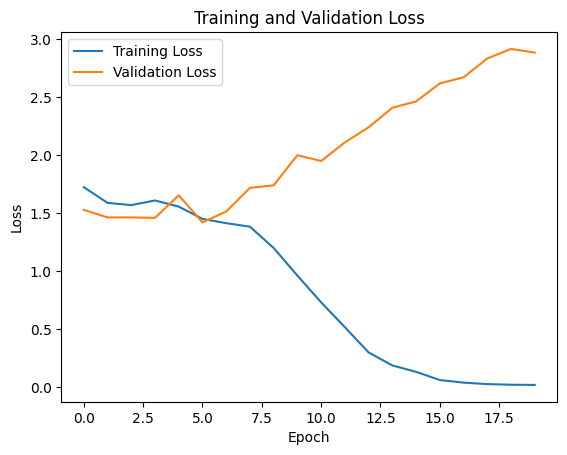

In [7]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    model.eval()
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

In [10]:
import numpy as np

In [11]:
predicted_classes, true_classes = [], []
for i in range(len(predicted_values)):
    predicted_values_i = predicted_values[i]
    val_values_1 = val_values[i]

    prediction_prob = torch.nn.functional.softmax((torch.from_numpy(np.array(predicted_values_i))), dim=0)
    predicted_class = prediction_prob.argmax(dim=0).item()
    true_class = np.argmax(np.array(val_values_1))

    print(f'predicted class: {predicted_class}, true class: {true_class}')
    print(f'prediction prob: {prediction_prob}\n\n')

    predicted_classes.append(predicted_class)
    true_classes.append(true_class)

predicted class: 0, true class: 1
prediction prob: tensor([9.7158e-01, 7.3879e-03, 2.0981e-02, 5.0987e-05], dtype=torch.float64)


predicted class: 1, true class: 1
prediction prob: tensor([0.0985, 0.8928, 0.0033, 0.0054], dtype=torch.float64)


predicted class: 3, true class: 1
prediction prob: tensor([5.6776e-04, 7.6827e-04, 2.0754e-03, 9.9659e-01], dtype=torch.float64)


predicted class: 0, true class: 1
prediction prob: tensor([0.8445, 0.0051, 0.0924, 0.0580], dtype=torch.float64)


predicted class: 1, true class: 2
prediction prob: tensor([6.2090e-04, 8.9307e-01, 7.6371e-03, 9.8672e-02], dtype=torch.float64)


predicted class: 2, true class: 2
prediction prob: tensor([4.5164e-04, 1.8274e-01, 5.5388e-01, 2.6293e-01], dtype=torch.float64)


predicted class: 1, true class: 2
prediction prob: tensor([0.0347, 0.9380, 0.0013, 0.0260], dtype=torch.float64)


predicted class: 0, true class: 1
prediction prob: tensor([0.3797, 0.0787, 0.3180, 0.2236], dtype=torch.float64)


predicted class:

In [12]:
predicted_classes = torch.from_numpy(np.array(predicted_classes))
true_classes = torch.from_numpy(np.array(true_classes))

In [13]:
((predicted_classes == true_classes).sum() / true_classes.shape[0]).item()

0.29499998688697815

In [3]:
model_final = Swin_Transformer.Swin_Transformer_model(
    drop_rate=0.1,
    patch_norm=True,
    linear_in_dim=46080,
    out_features=4,
    classification_target=True
)

weights_file = '../models/save/SWIN_classification_weights.pt'
# load check point
model_final.load_state_dict(torch.load(weights_file)['model_state_dict'])

c:\Users\ahmed\anaconda3\envs\vstp\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [5]:
train_loader, val_loader = get_train_and_val_loader(
    input_type='video_pack_100_holdout_swin',
    batch_size=20,
    verbose=True,
    target_type='classification'
)

torch.Size([3, 20, 128, 72])
torch.Size([3, 20, 128, 72])
80
20


In [6]:
import numpy as np

val_values = []
predicted_values = []

for inputs, targets in train_loader:
    model_final.eval()
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model_final(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

for inputs, targets in val_loader:
    model_final.eval()
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model_final(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

predicted_classes, true_classes = [], []
for i in range(len(predicted_values)):
    predicted_values_i = predicted_values[i]
    val_values_1 = val_values[i]

    prediction_prob = torch.nn.functional.softmax((torch.from_numpy(np.array(predicted_values_i))), dim=0)
    predicted_class = prediction_prob.argmax(dim=0).item()
    true_class = np.argmax(np.array(val_values_1))

    print(f'predicted class: {predicted_class}, true class: {true_class}')
    print(f'prediction prob: {prediction_prob}\n\n')

    predicted_classes.append(predicted_class)
    true_classes.append(true_class)

predicted class: 3, true class: 3
prediction prob: tensor([9.7102e-03, 1.0108e-01, 5.4436e-04, 8.8866e-01], dtype=torch.float64)


predicted class: 0, true class: 1
prediction prob: tensor([0.9360, 0.0230, 0.0352, 0.0058], dtype=torch.float64)


predicted class: 0, true class: 1
prediction prob: tensor([0.6455, 0.3323, 0.0168, 0.0054], dtype=torch.float64)


predicted class: 3, true class: 1
prediction prob: tensor([0.0169, 0.0218, 0.3314, 0.6299], dtype=torch.float64)


predicted class: 2, true class: 3
prediction prob: tensor([0.0096, 0.3179, 0.3462, 0.3263], dtype=torch.float64)


predicted class: 3, true class: 2
prediction prob: tensor([0.3243, 0.1134, 0.2373, 0.3250], dtype=torch.float64)


predicted class: 2, true class: 0
prediction prob: tensor([0.1126, 0.2032, 0.6640, 0.0203], dtype=torch.float64)


predicted class: 2, true class: 2
prediction prob: tensor([0.1738, 0.1941, 0.5824, 0.0498], dtype=torch.float64)


predicted class: 2, true class: 2
prediction prob: tensor([0.046

In [7]:
predicted_classes = torch.from_numpy(np.array(predicted_classes))
true_classes = torch.from_numpy(np.array(true_classes))

In [8]:
((predicted_classes == true_classes).sum() / true_classes.shape[0]).item()

0.27000001072883606